# Reinforcement learning (one-step Q-learning)

We consider a type of game where an *agent* takes at each time step an *action* $a$, for example taking a step in some direction or placing a stone on a Go board. Before taking the action, the system or environment that the agent lives in is in some *state*, $s$. (For example, in a game of Go, the state is the configuration of stones on the board.) After the action, the environment responds in some way (the agents stone is placed and the opponent places a stone) resulting in a new state of the system, $s'$. In the general case, the transition $s\rightarrow s'$ would result in some reward $r$ given to the agent (negative or positive or zero). (For the Go game the reward maybe only given at the end, positive if the game is won, negative if it is lost. This is problem with so called sparse-reward, which is particularly difficult.) 

The objective of the game is to get to the end of the game with the highest *return*, $R$, where return is the cumulative reward. When calculating the return it is customary (and important for many problems) to use a discounting factor $0<\gamma\leq 1$, that implies that reward further on is less valuable than immediate reward. With this, the return at time $t$ is defined as $R_t=\sum_{t'=t}^\infty\gamma^{t'-t}r_{t'}$, where there is an implicit assumption that we are following some particular sequence of actions with the corresponding rewards. 

To decide what action $a$ to take in a given state $s$ the agent uses a policy $\pi(s,a)$, which could correspond to a unique choice or a probability distribution. We are interested in finding the "optimal" policy $\pi_{opt}$, that in any state $s$ will give the maximum return when following it to the end.

A useful object to quantify the whole procedure is the "action-value" function $Q(s,a)$. It is defined as the return given by taking $a$ in $s$ and subsequently following the optimal policy, which can be written in an iterative form $Q(s,a)=r+\gamma\max_{a'}Q(s',a')$. Thus, correspondingly, the optimal policy will in fact be the one that in each step uses the action that maximizes $Q$, i.e. to find $\pi_{opt}$ we should calculate $Q$.

To calculate $Q$ we need to explore the set of states, taking different actions, and collect rewards. There are different ways of doing this, but a standard way is to do "one-step Q-learning" using an $\epsilon$-greedy policy. It goes as follows:

-  in state $s$ use your current estimate of $Q(s,a)$ to decide on the best action $a$ (maximizing $Q$). Use this action with probability $1-\epsilon$, but with probability $\epsilon$ take a random action. $0\leq\epsilon\leq 1$ is a parameter that quantifies a trade-off between exploiting the current best estimate of the optimal policy and to explore the full space of possible rewards. (For problems with very big state-action space it is not possible to explore the full space, thus necessary to use a small $\epsilon$, while for small worlds one can even use $\epsilon=1$.) 

- feed action $a$ to the environment that will respond by moving to state $s'$ and giving reward $r$. 

 - this last move provides an estimate 
$r+\gamma\max_{a'}Q(s',a')$ for $Q(s,a)$. (Note that this is not necessarily the correct value for $Q(s,a)$ as the next time you take action $a$ in state $s$ you may get a different reward, $Q(s',a')$ may have changed, and you may even end up in a different state $s'$ if there is some stochastic ingredient in moving between states.) Increment your value (estimate) by mixing in some part ($\alpha<1$) of the most recent estimate 
$Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$. (This is what "one-step" implies; we could have explored further, weighing the rewards of several steps into the upgrade of $Q$.)

- keep playing, from state $s'$ take another $\epsilon$-greedy action $a'$ to state $s''$ and update $Q(s',a')$. (Restart the game if you reach a terminal state.) Unless you get stuck in some part of the state-action space you will converge to the correct $Q$ function and the corresponding optimal policy after many games. 

--------------
**Construct an RL agent using one-step Q-learning to find the optimal path from start to finish in a "grid world".**

The grid world is a rectangular board where the agent can move in the cardinal directions. The board is surrounded by sheer cliffs giving death and a large negative reward. There are also a "fire" on the board, which is not fatal but gives a large negative reward. In addition, to make things more intersting, there is a treacherous "wind" that can make you go in a completely unintended direction. Every step also gives a negative reward; you want to get to goal in as few steps as possible. Reaching goal gives the only positive reward available on the board.

---------------

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from IPython.display import display, clear_output
import copy
from collections import deque
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

In [2]:
# Setup grid
startpos = np.array([0, 29])
goalpos = np.array([20, 0])
shortcut_target = np.array([15, 0])
size_grid_x = 30
size_grid_y = 40

# Setup Q matrix (size,size,4) matrix for the 4 actions up,down,left,right=0,1,2,3
Q = np.zeros((size_grid_x, size_grid_y, 4))
Q[1, 2, 3]

0.0

In [3]:
# the reward associated with each obstacle
reward_list = {"fire": -50, "cliff": -100, "goal": 100, "start": -1, "-": -1, "short-cut": -1}
# the state of the game: 1 meaning the game has ended
state_list = {"fire": -1, "cliff": 1, "goal": 1, "start": -1, "-": -1, "short-cut": -2}
reward_list["fire"]

-50

Next we define a function that constructs the grid (it is a nested list, not a numpy array)

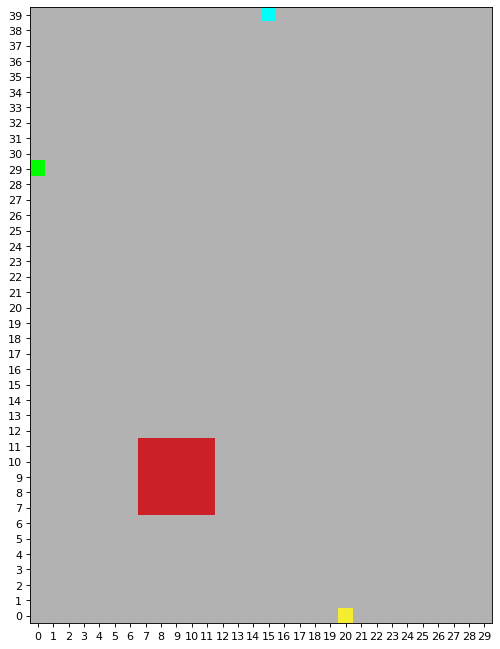

In [4]:
# Make grid
def make_grid():
    # Add padding, add an extra row, accessible through index -1
    grid = [["-" for y in range(size_grid_y + 1)] for x in range(size_grid_x + 1)]

    for x in range(size_grid_x + 1):
        for y in range(size_grid_y + 1):
            # Note that the range of values are between 0 and size_grid

            # goal
            if x == goalpos[0] and y == goalpos[1]:
                # store object
                grid[x][y] = "goal"

            # cliff
            if x == size_grid_x or y == size_grid_y:
                grid[x][y] = "cliff"

            # fires
            if (7 <= x <= 11) and (7 <= y <= 11):
                grid[x][y] = "fire"

            if x == startpos[0] and y == startpos[1]:
                grid[x][y] = "start"

            # short-cut
            if x == 15 and y == 39:
                grid[x][y] = "short-cut"

    return grid


# Plot grid, pass None if you do not want to print a path
def dispGrid(grid, path):
    grid_RGB = np.ones((size_grid_x, size_grid_y, 3)) * 0.7  #

    if path is not None:
        for i, location in enumerate(path):
            grid_RGB[location[0], location[1], :] = np.array([0, 0, 0])  # black'P' #player

    for x in range(size_grid_x):
        for y in range(size_grid_y):
            if grid[x][y] == "goal":
                grid_RGB[x, y, :] = np.array([245 / 255, 237 / 255, 48 / 255])  # Yellow

            if grid[x][y] == "fire":
                grid_RGB[x, y, :] = np.array([203 / 255, 32 / 255, 40 / 255])  # Red '-' 

            if grid[x][y] == "start":
                grid_RGB[x, y, :] = np.array([0 / 255, 254 / 255, 0 / 255])  # Green '-' 
                
            if grid[x][y]=='short-cut':
                grid_RGB[x,y,:] = np.array([0/255,254/255,250/255]) # Blue '-' 

    return grid_RGB


grid = make_grid()
# convert it to colors
plot_grid = dispGrid(grid, None)

fig = plt.figure(figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k")
plt.imshow(np.swapaxes(np.array(plot_grid), 0, 1))
# plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, size_grid_x, dtype=int))
plt.yticks(np.arange(0, size_grid_y, dtype=int))
plt.show()

The choice of parameters $\alpha, \beta, \epsilon $ for training represents a balance between learning efficiency and exploration-exploitation trade-off.

$\alpha $ or the learning rate (0.5) controls how quickly the agent incorporates new information into the Q-values. This value helps in effectively updating the Q-values without overshadowing the past learning.

$\beta $ or the discount factor (0.95) determines the importance given to future rewards. A value close to 1, indicates that future rewards are nearly as important as immediate rewards, promoting strategies that consider long-term benefits rather than just short-term gains- which is quite relevant for the considered grid world scenario.

$\epsilon $ or the exploration rate is initially set high (0.9), as it facilitates extensive exploration of the environment at the beginning when the agent knows little about the rewards associated with different actions in different states. This high initial value ensures that the agent does not quickly converge to a suboptimal policy based on limited early experiences. Over-time, the decay epsilon gradually shifts towards exploiting the learned values as the agent's knowledge base grows.

In [5]:
alpha= 0.5 #learning rate <1, if big it will train quickly, but also forget old experiences 
gamma= 0.95 #discounting rate <=1, how many steps ahead does it need to see?
epsilon= 0.9 #for the epsilon-greedy policy, the agent starts with no knowledge so it needs to explore to learn 
            #might be useful to decrease this as the agent learns more
wind=0.25 # chance that action results in random move instead of intended action. 
epsilon_decay = 0.99  # Decay rate for epsilon per episode
epsilon_min = 0.1  # Minimum epsilon value to ensure some exploration

As a first step we write a function `action_fcn(q_in, epsilon, wind)` which takes as input 
`q_in`, `epsilon`, `wind` and gives `move`, `action` as output.

The variable `q_in` are the action values for the four different actions 0,1,2,3 (corresponding to up, down, left, right) in a state given by the position of the agent. So if `position` is the current state `q_in=Q(position[0], position[1], :)`.

The output `action` should be the action selected according to the epsilon greedy procedure, i.e. 0,1,2 or 3. This action should be mapped to a `move` that specifies how to update `position`. However, we will also include wind which means that the actual move taken by the player should have a probability `wind` to be just a random move in any direction. Let `move` be the actual move performed when wind is taken into account. In other words, the agent will think it takes `action`, but it may actually take `move`, resulting in a different subsequent state and reward, than the agent intended.

In [6]:
def action_fcn(q_in, epsilon, wind):      # Implement the action selection function
    # select an epsilon greedy action based on q_in
    if np.random.rand() < epsilon:
        action = np.random.randint(4)  # Randomly choose action- Exploration
    else:
        action = np.argmax(q_in)  # Select best action from the Q-values- Exploitation

    # construct the corresponding move. One way to implement this is match action 0, or Up, to array (0,1),
    # action 1, down, to (0,-1) etc, making it easy to upgrade the postition, as position=position+move

    # test for wind, if True, make move random.
    if np.random.rand() < wind:
        action = np.random.randint(4)  # Wind

    move_dict = {
        0: np.array([-1, 0]),  # Up
        1: np.array([1, 0]),   # Down
        2: np.array([0, -1]),  # Left
        3: np.array([0, 1])    # Right
    }
    move = move_dict[action]  # Determine the move based on the selected or altered action

    # Outout
    return move, action

Epsilon ($\epsilon$) controls the agent's learning strategy by balancing exploration and exploitation. So, with probability $\epsilon$, the agent chooses a random action (exploration); with probability (1-$\epsilon$), it chooses the best-known action (exploitation). This ensures that the agent explores various actions to discover the optimal policy. For our value ($\epsilon$ = 0.9), the agent explores 90% of the time and exploits 10% of the time.

While wind, introduces randomness in the environment, affecting the outcome of agent's chosen actions. Thus, after our action is chosen, there is a probability equal to the wind parameter that a different, random action is taken. This simulates environmental unpredictability and real-world conditions. For our value (wind = 0.25), there is a 25% chance that the intended action will be replaced by a random action.

In short, epsilon ensures that agent explores the action space to learn effectively, while wind introduces stochasticity in the environment, leading the agent to handle unpredictability.

The next step is to implement the actual learning algorithm, which consists of playing the game many times and learn the Q-function. The cell gives a backbone of code, but some things need to be added, including updating the Q-function.

To train the agent loop through a big number of games. Run each game until you go outside the grid, the 'cliff', or if you reach the goal. 

This training can be done in several steps, possible using different training parameters, epsilon, gamma, and alpha. Evaluate the progression using the evaluation routines at the end of the notebook. Depending on parameters it may take several 100,000 games to get good convergence. 
#### We now, train two different agents to find the best path for the following two different scenarios: 
1) `wind=0.0` and 
2) `wind=0.25`

In [7]:
# reset Q function when changing the wind
Q=np.zeros((size_grid_x,size_grid_y,4))

# loop over games
nr_of_games=1000
for game in range(nr_of_games):
    # Initilize the player at the start position and store the current position in position
    position=startpos.copy()   # Start each game from the initial position
    reaction = -1   # Game status
    
    # loop over steps taken by the player
    while reaction == -1:    #the status of the game is -1, terminate if 1 (see state_list above)

        q_in = Q[position[0], position[1], :]  # Get current Q-values for the current position
    
        # Find out what move to make using current Q-values, epsilon, and wind
        move, action = action_fcn(q_in,epsilon,wind)
        
        # update location, check grid,reward_list, and state_list 
        position_new=position + move
        position_new = np.clip(position_new, [0, 0], [size_grid_x-1, size_grid_y-1]) #new position is within grid bounds
        
        obstacle = grid[position_new[0]][position_new[1]]       # Check type of cell at new position 
        reward = reward_list[obstacle]
        reaction = state_list[obstacle]
        if reaction==-2:
            position_new=shortcut_target.copy()
        
        # Update Q, using one-step Q-learning according to the equation in the introduction. 
        if reaction != 1:  # Check if it is not terminal state
            # Best Q-value for the next state
            max_future_q = np.max(Q[position_new[0], position_new[1], :])
            Q[position[0], position[1], action] = (1 - alpha) * Q[position[0], position[1], action] + alpha * (reward + gamma * max_future_q)
            
        # Remember that it is action that determines what entry of the Q-matris that should be updated, not move
        # If action is to a terminal state there is no next action, the Q function is then updated only by the reward
        else:
            Q[position[0], position[1], action] = (1 - alpha) * Q[position[0], position[1], action] + alpha * reward
        # Take care in how it is defined at the boundary, make use of the fact that index -1 addresses last entry 
    
        position = position_new           # Move to new position

    if game % 100 == 0:
        print(f'game nr= {game}')
        print(f'Max Q-value: {np.max(Q)}, Min Q-value: {np.min(Q)}')
        # You might want to print some more diagnostics here like max and min values of Q, which should be in the 
        # range of maximal and minimal rewards

game nr= 0
Max Q-value: 0.0, Min Q-value: -1.1125
game nr= 100
Max Q-value: 99.99998807907104, Min Q-value: -144.85761300786032
game nr= 200
Max Q-value: 99.99999997671694, Min Q-value: -143.23446849377308
game nr= 300
Max Q-value: 99.9999999992724, Min Q-value: -140.43917279802912
game nr= 400
Max Q-value: 99.9999999998181, Min Q-value: -140.43917279802912
game nr= 500
Max Q-value: 99.99999999999432, Min Q-value: -140.43917279802912
game nr= 600
Max Q-value: 99.99999999999432, Min Q-value: -134.13843635744422
game nr= 700
Max Q-value: 99.99999999999964, Min Q-value: -127.78414777836069
game nr= 800
Max Q-value: 99.99999999999996, Min Q-value: -127.78414777836069
game nr= 900
Max Q-value: 100.0, Min Q-value: -127.78414777836069


In [8]:
def train_agent(num_episodes, startpos, grid, wind, epsilon_decay, epsilon_min, alpha, gamma, max_steps_per_episode, Q):
    epsilon = 0.9    # Initialize epsilon 

    for episode in range(num_episodes):
        position = startpos.copy()
        reaction = -1

        for step in range(max_steps_per_episode):
            q_in = Q[position[0], position[1], :]
            move, action = action_fcn(q_in, epsilon, wind)  # epsilon for exploration-exploitation decision
            position_new = position + move

            # Ensure position is within bounds
            position_new = np.clip(position_new, [0, 0], [size_grid_x - 1, size_grid_y - 1])

            obstacle = grid[position_new[0]][position_new[1]]
            reward = reward_list[obstacle]
            reaction = state_list[obstacle]

            if reaction == -2:
                position_new = shortcut_target

            if reaction == 1:  # Terminal state
                Q[position[0], position[1], action] = (1 - alpha) * Q[position[0], position[1], action] + alpha * reward
                break
            else:
                max_future_q = np.max(Q[position_new[0], position_new[1], :])
                Q[position[0], position[1], action] = (1 - alpha) * Q[position[0], position[1], action] + alpha * (reward + gamma * max_future_q)
            
            position = position_new

        epsilon = max(epsilon_min, epsilon * epsilon_decay)       # Epsilon decay after each episode
        
    return Q

def simulate_path(Q, startpos, shortcut_target, wind):
    position = startpos
    path = np.array([startpos])
    reaction = 0
    step_count = 0

    while reaction != 1 and step_count < 100:  # Limit steps to avoid infinite loops
        q_in = Q[position[0], position[1], :]
        move, action = action_fcn(q_in, 0.0, wind)  # Take the optimal move: epsilon=0 for greedy
        position_new = position + move
        position_new = np.clip(position_new, [0, 0], [size_grid_x - 1, size_grid_y - 1])       # Handle boundaries

        obstacle = grid[position_new[0]][position_new[1]]
        reaction = state_list[obstacle]
        if reaction == -2:  position_new = shortcut_target
        position = position_new
        path = np.append(path, [position], axis=0)
        step_count += 1

    return path

def plot_path(grid, path, title):
    plot_grid = dispGrid(grid, path)
    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k")
    plt.imshow(np.swapaxes(np.array(plot_grid), 0, 1), origin='lower')
    plt.gca().invert_yaxis()  # Depending on your grid setup, you might need to adjust this
    plt.xticks(np.arange(0, size_grid_x, dtype=int))
    plt.yticks(np.arange(0, size_grid_y, dtype=int))
    plt.title(title)
    plt.show()

    
# Training parameters
alpha = 0.5  # Learning rate
gamma = 0.95  # Discount rate
epsilon = 0.9
epsilon_decay = 0.99
epsilon_min = 0.1
num_episodes = 5000  # Adjust as necessary for convergence
max_steps_per_episode = 100
epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Initialize Q matrices
Q_no_wind = np.zeros((size_grid_x, size_grid_y, 4))
Q_with_wind = np.zeros((size_grid_x, size_grid_y, 4))

# Train for no wind
Q_no_wind = train_agent(num_episodes, startpos, grid, 0.0, epsilon_decay, epsilon_min, alpha, gamma, max_steps_per_episode, Q_no_wind)

# Train for wind
Q_with_wind = train_agent(num_episodes, startpos, grid, 0.25, epsilon_decay, epsilon_min, alpha, gamma, max_steps_per_episode, Q_with_wind)

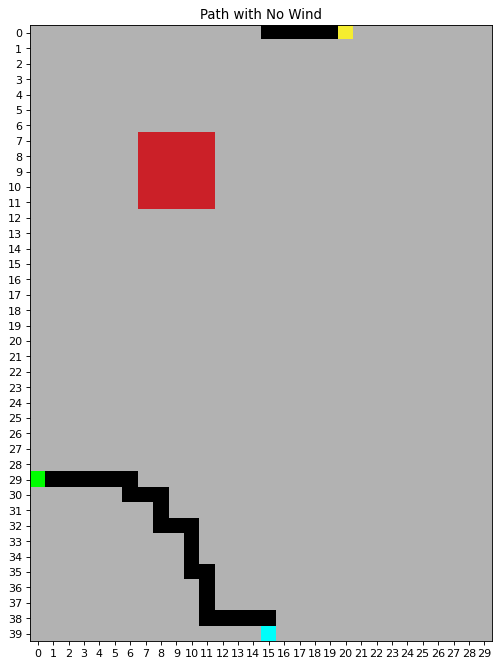

In [9]:
path_no_wind = simulate_path(Q_no_wind, startpos, shortcut_target, 0.0)
plot_path(grid, path_no_wind, "Path with No Wind")

The figure shows the agent's path in an environment without any stochastic effects like wind. The path is direct and efficient, demonstrating successful learning of the optimal route to the goal.


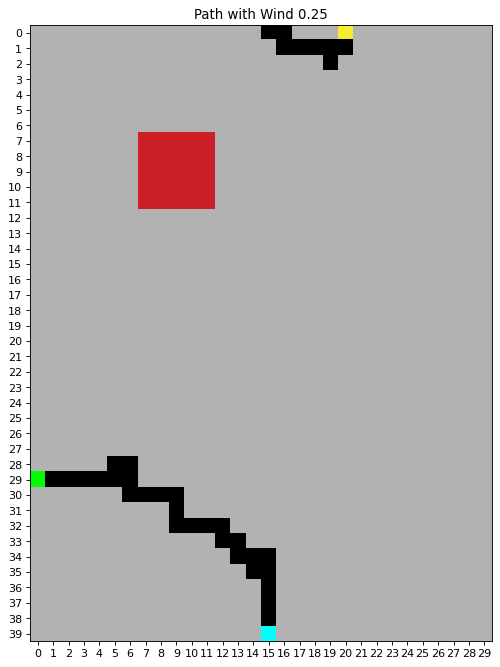

In [10]:
path_with_wind = simulate_path(Q_with_wind, startpos, shortcut_target, 0.25)
plot_path(grid, path_with_wind, "Path with Wind 0.25")

Comparing the two plots above for without wind and 0.25 probability for wind, we can differentiate the plots on three levels. Firstly, the efficiency- The path without wind is likely more efficient, taking fewer steps to reach the goal due to the absence of disruptive external factors. Secondly, robustness- While the path with wind appears less efficient, this scenario tests the robustness of the agent’s policy against environmental disturbances. Training with wind can potentially lead to a more robust policy that performs better in varied and unpredictable real-world conditions. And lastly, learning deapth- The scenario with wind requires the agent to learn not only the optimal path but also how to recover from suboptimal positions. This could lead to a deeper understanding of the environment, but at the cost of efficiency.

But overall, the agents path with no wind appears more direct and systematic. As the agent relies solely on the learned Q-values to make decisions, without the wind's influence. On the other hand, the path with wind shows more deviations and irregularities. The introduction of wind with a 25% chance of altering the chosen action results in stochastic behavior. This randomness means that even if the agent intends to move in a particular direction based on its learned Q-values, there's a significant chance it will be forced into an unintended action.

## Plot routines

The state value function ($V(s)$) represents the maximum expected return (cumulative reward) starting from state $(s)$ -nd following the optimal policy. It indicates how valuable it is for the agent to be in a particular state, considering future reward

$V(s)$ is derived from ($Q(s, a)$) by taking the maximum Q-value over all possible actions $(a)$ at state $(s)$, such that:

$$
V(s) = max_a Q(s,a)
$$

$V(s)$ is the highest value obtainable from state $(s)$,
s by choosing actions optimally. It summarizes the best possible outcome starting from $(s)$.

So, $V(s)$ provides the value of being in a state under the optimal policy, while $Q(s, a)$ gives the expected return for taking a specific action in that state $(s)$.

<Figure size 640x480 with 0 Axes>

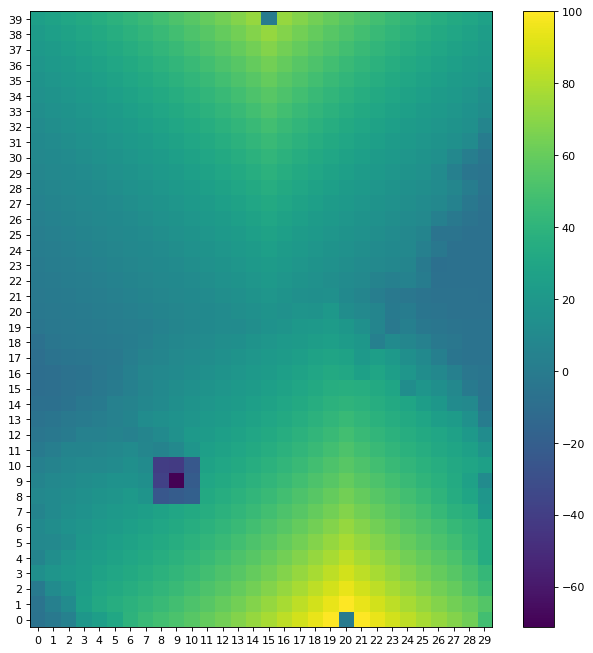

In [11]:
# Value function
z = Q.max(axis=2)
# z=z.T
# z=np.flip(z,axis=0)
# z=np.flip(z,axis=1)
plt.figure()
fig = plt.figure(figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k")
plt.imshow(np.swapaxes(z, 0, 1))
plt.colorbar()
# plt.grid(False)
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, size_grid_x, dtype=int))
plt.yticks(np.arange(0, size_grid_y, dtype=int))
plt.show()

The best path found by the agent is directly linked to the plot of the state value $V(s)$, where it is defined as the maximum expected future rewards from each state, following the optimal policy. The state value function derives $V(s)$ based on the Q-values indicating the best possible return from state $(s)$ when the optimal action $(a)$ is chosen. The best path consists of states that the agent chooses based on the highest $V(s)$, leading towards the goal- most rewarding route. Lastly, the plot of $V(s)$ shows higher values along the optimal path and lower values away from it, mapping out the landscape of rewards the agent expects to accumulate.

In [12]:
# a path
position = startpos
path = np.array([startpos])
reaction = 0
step_count = 0
while reaction != 1:
    q_in = Q[position[0], position[1], :]
    step_count += 1
    move, action = action_fcn(q_in, 0.0, 0.0)  # take optimal move
    position_new = position + move

    obstacle = grid[position_new[0]][position_new[1]]
    reaction = state_list[obstacle]

    if reaction == -2:
        position_new = shortcut_target

    position = position_new

    path = np.append(path, [position], axis=0)

    if step_count > 100:
        break
print(path, step_count)

[[ 0 29]
 [ 1 29]
 [ 2 29]
 [ 3 29]
 [ 4 29]
 [ 4 30]
 [ 5 30]
 [ 6 30]
 [ 7 30]
 [ 8 30]
 [ 8 31]
 [ 9 31]
 [ 9 32]
 [ 9 33]
 [ 9 34]
 [ 9 35]
 [10 35]
 [11 35]
 [12 35]
 [12 36]
 [12 37]
 [13 37]
 [13 38]
 [14 38]
 [15 38]
 [15  0]
 [16  0]
 [17  0]
 [18  0]
 [19  0]
 [20  0]] 30


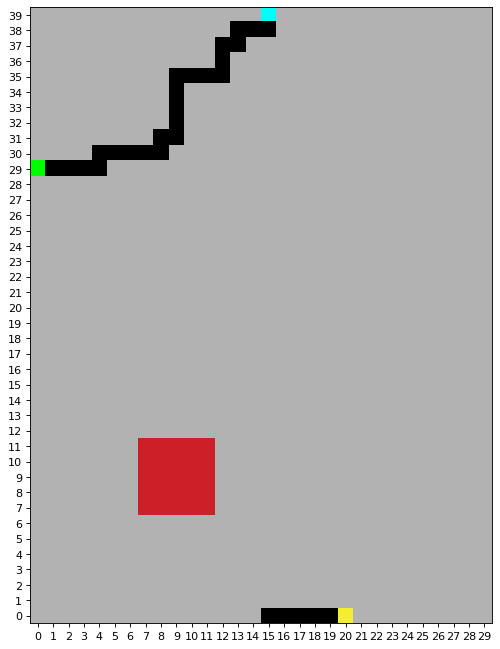

In [13]:
# plot above path
grid = make_grid()
plot_grid = dispGrid(grid, path)

fig = plt.figure(figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k")
# We have to invert the x and y axis , go over to numpy array instead
plt.imshow(np.swapaxes(np.array(plot_grid), 0, 1))
# plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, size_grid_x, dtype=int))
plt.yticks(np.arange(0, size_grid_y, dtype=int))
plt.show()

# Deep Reinforcement learning

Earlier, we found a $Q$-matrix that described the values of taking the action up,down,left or right given the state we were in. The state was simply given by the position of the player who lived on a $20\times 30$ grid corresponding to $600$ possible states; the state space. The $Q$-matrix was quite small ($600\times 4$) and we had no problem storing all the values and go through them many times and update until the values converged. However, this smallness of the state space is not expected in general.

In this assignment we will include a little twist to the game, which makes the state space size explode. What we will do is to let the fire spread with a certain probability after every turn of the player. For the sake of relative simplicity we will consider a $10\times 10$ grid. The player has $100$ possible positions but the fire can occupy any grid, or not, meaning that we have $100 \cdot 2^{100} \approx 10^{32}$ possible states. This is a huge number and there is no way of even storing this number of $Q$-matrix entries, even less so going through and updating all these values repeatedly. Of course, in principle the problem sounds quite simple. There should be no need to tune $10^{32}$ degrees of freedoms to learn the simple task of just avoiding the fire, but exactly how to capture that intuition in a self learning mathematical framework is less clear. (An alternative could be to use a rule based solution, but here we want the agent to learn the rules itself.) This is where the neural network comes in. As we have seen before in the course, a neural network can learn general features of data. For the present problem it amounts to taking the state as an input and giving the value of the different actions as an output, i.e. we use the network to represent the $Q$-matrix. As you will see you will actually only need a very small number of parameters (compared to $10^{32}$) in your network to solve this problem.

The ground breaking paper that popularized deep Q-learning: [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236)


### Training

What we need to alter from the previous assignement is to implement the network as the $Q$-function. The update of the $Q$-function: $Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$, must then be replaced with the learning step of the network. This step meant that $r+\gamma\max_{a'}Q(s',a')$ was the new estimate of $Q(s,a)$, thus using the neural network we will then train with $t=r+\gamma\max_{a'}Q(s',a')$ as target for $Q(s,a)$. In practice, the network will have the state $s$ as input, and the 4 movement actions as output, with $t$ the training target for one of these actions.

So far everything seems like a quite straight forward generalization of the previous assignment. However, training the neural network for this purpose is a quite tricky business. We will review a few problems and cures below. 


###  Catastrophic forgetting and experience replay

The first problem one might encounter when using the network instead of simply storing all the values of the $Q$-matrix is that of catastrophic forgetting. This is easiest explained with an example; Let's assume that the player has the goal on its left hand side and the cliff on its right hand side. It now takes a step to the left and receive a reward for this, the network is then trained on this situation and learns to correlates some  feature of this state to the action of taking a step to the left. In the next game it might happen so that the player ends up with the goal to the right and the cliff to the left. With the network being trained on this the previous move it might see some common features of these two states and decides to make a move to the left, because it was what it had learned last time. However this time this results in a negative reward and is we now train on this event it is likely that the network erase what it previously learned. In this scenario we might go back and forth between these two events and not learn anything. 

Note that this could not happen if we had the complete $Q$ matrix entries for every single state, simply because the experiences are disjoint; updating one element of the $Q$-matrix will not effect any other value. However, for the network, training on one state will effect the output of another state. So the very property that make networks good for treating a large state space make them sensitive in this regard.

In order to solve this we need to make the network learn to tell the qualitative difference between the two states and actions it apparently thought looked quite similar. To do this we to train on both experiences simultaneously or at least repetively. In practice this is done by setting up a memory in which we store a certain number of the  recent experiences, possibly going back quite far. When we come to the training we draw a random sample from this memory and train on it. This is called _experience replay_.

### Policy and target networks

Another issue is that the network may become unstable and the training might start to diverge. This problem comes partly from the fact that we use the network in order to predict future rewards, rewards that in the beginning are completely random. This means that the network will learn from its own prediction which can lead to a runaway situation. A cure for this is to use two networks: a _policy_ network and a _target_ network. These networks should have exactly the same architecture, they are just updated in different pace. The policy network determines the action of the player and is the network which is trained in the training step. The target network determines the target of the training, that is predicts $\max_{a'}Q(s',a')$, and is updated less frequently. The target network is updated by copying the weights of the policy network and assigning them to the target network, so the target network is never trained, it is just a copy of the policy network. By delaying the feedback to the target values in the training step the instability might be avoided.

## Code:

The code defines a class GridWorld. Classes are a standard tool of object oriented programming languages such as Python. If you want you can read up on classes check [w3schools](https://www.w3schools.com/python/python_classes.asp) for a short version and [The Python tutorial](https://docs.python.org/2/tutorial/classes.html) for a more extensive one, but it should not be necessary to solve the assignment. The main point is that you treat objects (or instances) of that class. You do this by calling the constructor to get an object of the class, e.g. below we write <code>world = GridWorld()</code> to get the object <code>world</code> of the class. Now you can call any function of variable in the class by <code>world.variable</code> or <code>world.function(parameters)</code>.


### State representation

To represent the state we have used an array consisting of three $10\times 10$ grid layers. The first specifies the position of the player with a 1 at the position of the player, otherwise zero, and if the player has walked outside the grid all elements are zero. The second layer specifies the position of the fire, with 1 where there is a fire and 0 otherwise. The third layer represents the goal and is fixed at the same position. I.e. <code>state[:,:,0]</code> gives the grid describing the position of the player, <code>state[:,:,1]</code> position of the fire and <code>state[:,:,2]</code> position of the goal.

## Hints


Below are some hints. _Read these before you start, and come back to them if your code runs but the training doesn't work._ Note that the parameter values stated are not necessarily the best values, it is just there to help you search in an appropriate parameter range.

$\bullet$ Your network should not need more than 100000 trainable parameters (we get a good agent using 15000 parameters). Remember, the output should be four real numbers corresponding to the four action values. (This is not a classification task for which softmax output and cross entropy loss are standard.) We have provided appropriate activation function for the last layer and corresponding loss function. Be careful if you change these.  

$\bullet$ To test the minimal requirements on your network you might want to try to disable the fire spread and perhaps also set <code>gamma = 0</code>, then then the network should learn the rewards of every square in the grid. 

$\bullet$ The output diagnostic of q_max and q_min gives an indication whether the network output is reasonable or not. The range of Q-values should be in the range of possible returns.   

$\bullet$ Beware of overfitting. If you train the network too much on a set of experiences it may be difficult to divert it to new data. Not having a too large fraction of the replay memeory as the training batch may help. Adding regularizers <code> kernel_regularizer </code> may also help. You can also change the number of epochs in the training module <code> replay </code>. 

$\bullet$ Make sure that use use big enough experience replay buffer. We need experience from quite many games in the past, on the order of 100, how many moves does the player do in each game? Considering this, how big should your memory then be. The <code>batchSize</code> is the number of experiences that are averaged over in each training instance of the network. The larger it is the more stable the training, but it also reduces the stochasticity which is important for good training. (Trial and error may be needed to find a good size.) 

$\bullet$ In general <code>gamma</code> needs to be quite large in order for the player to see the goal from far away in the grid. If your training becomes unstable for large <code>gamma</code> you should consider having a bigger memory. You can also try to make the synchronization between policy and target networks less frequent. 

$\bullet$ You will probably need to use a decay of <code>epsilon</code>, so that the player start out walking random but start listening more and more to the network. However, make sure that you do not quench <code>epsilon</code> to fast. A good idea might be to study how how the player is progressing as <code>epsilon</code> is lowered. If he never finds the goal when you reduced <code>epsilon</code> significantly, you probably reduces it to fast.

$\bullet$ You can consider whether to start at random position or at a fixed position, <code> random_start </code>, depending on how far you training has progressed. 

$\bullet$ It is a good idea to interrupt the training and assess how the learning progresses by studying the state value function. You should start seeing that the state values near the goal become higher.

$\bullet$ You will need to train for a few thousand games. However, you should be able to see progress after 1000 games.

In [14]:
# construct Gridworld class
class GridWorld:
     
    ##============ CONSTRUCTOR =============
    # This creates the instance of the class and is called by GridWorld().
    # The first argument in defining any function refers 
    # to the objects of the class currently handeled, often called self, but it could be anything.
    # Note that when calling the functions these first argument is left out, i.e. you only write GridWorld(), 
    # the first argument is automatically fed by python.
    def __init__(self):
        # the size of the grid
        self.size = np.array([10,10])
        # number of layers in state 
        self.layers = 3
        
        # Default starting position and goal
        self.start = np.array([1,8])
        self.goalpos = np.array([8,1])      
        
        # rewards, gravel refers to an ordinary step 
        self.cliff = -100
        self.fire = -50
        self.goal = 100
        self.gravel = -1
                
        # Default values for network
        self.gamma = 0       
        # Probability of wind
        self.wind = 0
        #probability for fire to spread
        self.prob_spread = 0
        
        # Default values for epsilon greedy, not optimal, updated further down!
        self.epsilon = 1
        self.epsilon_decay = 0.99999999999999999999999999
        self.epsilon_min = 0.1
        
        # Memory, default values, not optimal, updated further down!
        self.memory_size = 1 
        self.memory = deque(maxlen=self.memory_size)
        self.batchSize = 1 
        

        

##============ CREATE STATES =============
    # Constructs the state, random_placement is either True or False. If True the player is placed 
    # randomly, if False the player is initialized in the starting position
    
    def make_state(self,random_placement):
        
        if random_placement:
            r_x = np.random.randint(self.size[0]) 
            r_y = np.random.randint(self.size[1])
            # if random = goal keep generating values 
            while r_x == self.goalpos[0] and r_y == self.goalpos[1]:
                r_x = np.random.randint(self.size[0]) 
                r_y = np.random.randint(self.size[1])
        else :
            r_x = self.start[0]
            r_y = self.start[1]
        
        # Initialize all values in all layers to zero
        state = np.zeros((self.size[0],self.size[1],self.layers))
        # we will use player_coordinate to keep track of the position of the player
        player_coordinate = [0,0]

        # Go through all layers and put 1 at the correct position
        for x in range(self.size[0]) : 
            for y in range(self.size[1]) :
            
                # Player, first layer
                if x == r_x and y == r_y :
                    state[x,y,0] = 1
                    player_coordinate[0] = x
                    player_coordinate[1] = y
                else : 
                    state[x,y,0] = 0

                       
                # Fire, second layer
                if (1<= x <=2) and (1<= y <= 2):
                    state[x,y,1] = 1    
                else :
                    state[x,y,1] = 0 
            
                #Goal, thrid layer
                if x == self.goalpos[0] and y == self.goalpos[1] :
                    state[x,y,2] = 1
                else : 
                    state[x,y,2] = 0                
    
        # return state and player_coordinate
        return state , player_coordinate 
    
    
##============ MAKING MOVES IN GRIDWORLD ================
 
    # This function returns the new state, player position, reward of the move and a variable done
    # which tells us if the game is done or not. The arguments are the current state, action, player_coordinate
    # and is_wind which takes values True or False and determines if wind should be implemented.
    
    def make_move(self,state,action,player_coordinate,is_wind):
        # Use deepcopy to make a copy of the state, otherwise this would just be a pointer to the same
        # object as state. This is an inconvenience with python... 
        next_state = copy.deepcopy(state)
                
        if is_wind :
            if np.random.rand() < self.wind:
                # overwrite action with random action internally
                action = np.random.randint(4)
                
        new_x = player_coordinate[0]
        new_y = player_coordinate[1]
        
        # Assume that the player goes out of the board ,set old position to zero
        # and new coordinate to none
        next_state[new_x,new_y,0] = 0
        next_player_coordinate = None
        done = True
        reward = self.cliff
        
        # make move 
        if action < 2 : # up or down
            if action == 0: # up
                new_y = new_y + 1
            else : # down
                new_y = new_y - 1 
        else : # left or right
            if action == 2: # left 
                new_x = new_x - 1
            else : # right
                new_x = new_x + 1   

        # If inside grid 
        if 0<= new_x < self.size[0] and 0<= new_y < self.size[1] :
            # if it hits the goal
            if state[new_x,new_y,2] == 1:
                done = True
                reward = self.goal
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            # fire # WHAT IF THE GOAL BURNS?
            elif state[new_x,new_y,1] == 1 :
                done = False
                reward = self.fire
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            # gravel    
            else : 
                done = False 
                reward = self.gravel
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            
        # else, do nothing, next_player coordinate remains None and next_state[:,:,0] remains all zeros
            
        return next_state, next_player_coordinate , reward , done  

    


    
#============== SPREADING OF FIRE =====================

    # This function takes state and returns, new_state in which the fire has spread. There is 
    # a possibility that the fire did not spread, therefore it gives did_fire_spread which is True if the 
    # fire actually did spread, otherwise it is False.
    
    def let_fire_spread(self,state):
        new_state = copy.deepcopy(state)
        
        # Assume fire did not spread
        did_fire_spread = False
    
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                # Walk trhough the fire-grid, if encountering fire, see if it spreads
                if state[x,y,1] == 1 : 
                    # with the probability self.prob_spread the fire spreads 
                    if np.random.rand() < self.prob_spread :
                        # a random move , no diagonal moves are allowed
                        if np.random.rand() < 0.5 :
                            x_step = np.random.randint(2)*2-1
                            y_step = 0
                        else :
                            x_step = 0
                            y_step = np.random.randint(2)*2-1
                        # if within boundaries
                        if (0<= x+x_step < self.size[0]) and (0<= y+y_step < self.size[1]):
                            # Check that this square is not allready on fire
                            if new_state[x+x_step,y+y_step,1] == 0: 
                                # LET IT BURN!
                                new_state[x+x_step,y+y_step,1] = 1
                                did_fire_spread = True
                                
        
        return new_state , did_fire_spread
    
    
    
##============ TRAINING AND EXPERIENCE REPLAY ============= 
  
    # Replay implements the training and experience replay. Here we want to show two different implementations
    #, one of which is currently commented away in the main loop. The commented version, version 2, we use the
    # target network to predict new targets for old states. In version 1, the currently used version,
    # we recall the old predictions of the targets. We find that version 1 is more stable
    # than version 2 for this problem. But you can try out both versions.
    def replay(self, policy_model):

        # check if the memory is bigger than the batch size
        if len(self.memory) < self.batchSize :
            # if not recall whole memory
            minibatch = self.memory
        else :
            # otherwise take a random batch of size batchSize of the memory
            minibatch = random.sample(self.memory, self.batchSize)
   
        # initialize a state and a target batch for training
        state_batch = np.zeros((len(minibatch),self.size[0],self.size[1],self.layers))
        target_batch = np.zeros((len(minibatch),4))

        # Go through memory 
        i = 0
        for (state, q_state, action, reward, next_state, next_q_max, done) in minibatch :
            # Version 1:
            #target values for network are the same as the output of the network at the time the experience was made
            target = q_state.reshape(4) 
            #except for the action that was actually taken where we have a reward that we can use
            new_target = reward         
            if not done :
                # Version 1:
                new_target = reward + self.gamma * next_q_max
                
            target[action] = new_target
            # Put state and target in the training batch
            state_batch[i] = state
            target_batch[i] = target
            i = i + 1
                        
        # Train, the number of epochs for training can be changed 
        policy_model.fit(state_batch, target_batch, batch_size = len(minibatch), epochs=5, verbose=2)
            
 
            
            
##====================FOR DISPLAY==============================    

    # Used to display the grid
    def make_RGB_grid(self,state,path):
        grid_RGB = np.ones((self.size[0],self.size[1],3))*0.7 #
        
        if path is not None :
            for i,location in enumerate(path):
                grid_RGB[location[0],location[1],:] = np.array([0,0,0]) # black'P' #player
    
        for x in range(self.size[0]) : 
            for y in range(self.size[1]) :
            
                if state[x,y,2]==1:
                    grid_RGB[x,y,:] = np.array([245/255,237/255,48/255]) # Yellow
                
                if state[x,y,1]==1:
                    grid_RGB[x,y,:] = np.array([203/255,32/255,40/255]) # Red '-' #pit    
   
                if state[x,y,0]==1:
                    grid_RGB[x,y,:] = np.array([0/255,254/255,0/255]) # Green '-' #pit    
   
        return grid_RGB


# define the network

def setup_network(world) : 
    # setup network, world.size and world.layers give the input_shape
    opt=tf.losses.MeanSquaredError()  #loss function 
    model=Sequential()
    model.add(Conv2D(32, kernel_size=(3,3),padding='valid', activation='relu', input_shape=(world.size[0],world.size[1],world.layers)))
    model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))  # Fully connected layers
    
    # to transition from convolutional to dense layer, you need to Flatten, i.e. transform matrix to 1D array
    
    model.add(Dense(4, activation='linear'))
              
    # compile network          
    model.compile(loss=opt, optimizer='adam' ,metrics=['mse'])
    
    # return model 
    return model

The network consists of these layers: The first layer is a Conv2D layer that takes an input of dimensions (10, 10, 3) and outputs (8, 8, 32) with 896 parameters, extracting features using 32 filters of size 3x3. The second Conv2D layer takes (8, 8, 32) as input and outputs (6, 6, 64) with 18,496 parameters, extracting deeper features with 64 filters of size 3x3. The third Conv2D layer takes (6, 6, 64) as input and outputs (4, 4, 128) with 73,856 parameters, using 128 filters of size 3x3 for even deeper feature extraction. This is followed by a Flatten layer that converts the (4, 4, 128) output to a 1D feature vector of size 2048. Next, a Dense layer with 256 units and 524,544 parameters processes the features for complex pattern learning, followed by another Dense layer with 128 units and 32,896 parameters for further pattern learning. Finally, the output Dense layer has 4 units and 516 parameters, providing Q-values for the four possible actions.

## Setup network and GridWorld

C:\Users\omkarp\AppData\Local\miniconda3\envs\omkarp\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 8, 8, 32)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 651,204 (2.48 MB)

 Trainable params: 651,204 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

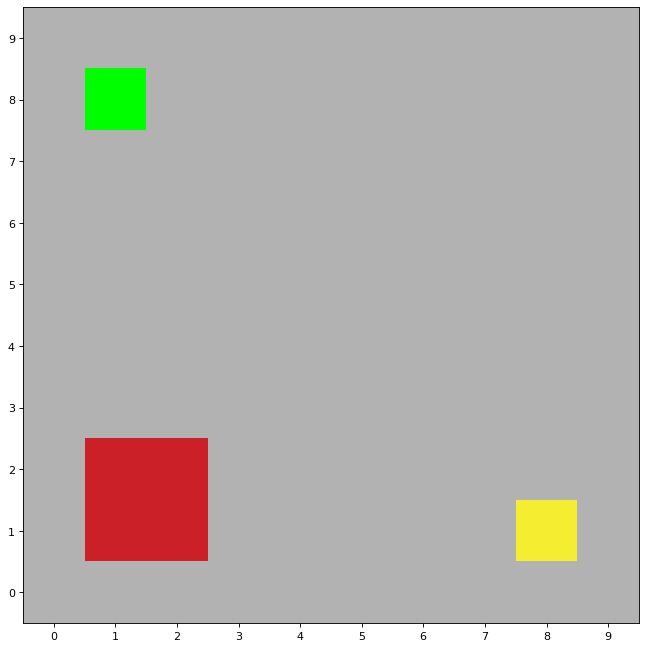

In [15]:
# Setup GridWorld and Q-networks

# Create world from GridWorld
world = GridWorld()
# Setup network
policy_model = setup_network(world)
#make a target network as well
target_model = setup_network(world)
# copy weights from policy to target
target_model.set_weights(policy_model.get_weights())

# Plot model summary
policy_model.summary()

#Make state 
state , player_coordinate = world.make_state(False)

# plot it 
grid_RGB =world.make_RGB_grid(state,None)
#
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
# We have to invert the x and y axis , go over to numpy array instead
plt.imshow(np.swapaxes(np.array(grid_RGB),0,1))
plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, world.size[0], dtype=int))
plt.yticks(np.arange(0, world.size[1], dtype=int))
plt.show()

In [16]:
# Train network on model- set system parameters

world.gamma = 0.99
world.epsilon_decay = 0.995 #multiplicative factor that reduces epsilon each step, for no reduction use 1
world.epsilon = 1.0  #initial value of epsilon 
world.wind = 0.1
# fire spreading
world.prob_spread = 0.5 # 

#update the target network every "update_target_network_period game". Updating target network less often should make
#the system more stable, but also convergence slower
update_target_network_period = 1000

#define size of experience replay buffer (how many moves are stored for training) 
#and batchsize (how many moves from memory buffer are used in each training instance)
world.memory_size = 2000 
world.batchSize = 32 
world.memory = deque(maxlen=world.memory_size)   #The experience replay memory

In [18]:
#For training diagnostics.  
q_max = 0
q_min = 0

# MAIN LOOP with network

step_count=0;
random_start = True  #Easier to train from random start
is_wind = False  #Set to false to simplify training 
next_player_coordinate = None
nr_games = 250
# loop over games
for games in range(nr_games):
    
    # Display
    print("Game #: %s" % (games,))
    print("Epsilon : %7.4f" % world.epsilon)     
    print("Step count : %s" % step_count) 
    print("End pos %s" % next_player_coordinate)
    
    # DIAGNOSTICS 
    print("Since updated target: Qmin  %s Qmax %s" % (q_min,q_max))
    
        
    # reinitize grid every game will be created at start position
    state , player_coordinate = world.make_state(random_start)
    
    step_count=0;
    while True :
        step_count+=1
        
        # use policy network to get q
        q_state = policy_model.predict(state.reshape(1,world.size[0],world.size[1],world.layers))        
        # get best action
        action = np.argmax(q_state)   
        
        # epsilon greedy
        if np.random.rand() < world.epsilon :
            # take another action
            action=np.random.randint(4)
            
        # make the move
        next_state ,next_player_coordinate, reward , done = world.make_move(state,action,player_coordinate,is_wind)
                  
        # find max q of the next state using target network
        next_q_max = np.amax(target_model.predict(next_state.reshape(1,world.size[0],world.size[1],world.layers)))
        
        # Store in memory
        world.memory.extend([(state, q_state, action, reward, next_state, next_q_max, done)])  
        
        # DIAGNOSTICS UPDATE   =============
        if q_max < np.amax(q_state):
            q_max = np.amax(q_state)
        if q_min > np.amin(q_state):
            q_min = np.amin(q_state)
            
        
        #=============================================
        
          
        # break if done or two many steps taken 
        if done or (step_count > 400): # 10^2 =100 steps to diffuse through the lattice
            break
        
        # update state
        state = next_state 
        player_coordinate = next_player_coordinate 

        # let fire spread 
        new_state, fire_spread = world.let_fire_spread(state)
        if fire_spread :
            state = new_state 
        
    
    # end of game, train the network every 10 games. Can be changed. 

    if (games % 10 == 0 and games>0 ):
        
        world.replay(policy_model)
        
        # epsilon decay
        if world.epsilon > world.epsilon_min:
            world.epsilon *= world.epsilon_decay 
            
    # update target network 
    if (games % update_target_network_period == 0) :
        print("Update target network")
        # update the weights of the target model
        target_model.set_weights(policy_model.get_weights())
        #reset diagnostic
        q_max = 0
        q_min = 0
    
    clear_output(wait=True)    
    # end of loop

Game #: 249
Epsilon :  0.7667
Step count : 14
End pos None
Since updated target: Qmin  -79.123856 Qmax 0.4711123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━

In [19]:
policy_model.save('policy_model.h5')
target_model.save('target_model.h5')
policy_model = load_model('policy_model.h5')
target_model = load_model('target_model.h5')
policy_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']) # build metrics
target_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

policy_model.summary()
target_model.summary() # compare

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 8, 8, 32)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 651,204 (2.48 MB)

 Trainable params: 651,204 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 651,204 (2.48 MB)

 Trainable params: 651,204 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

# Plotting : State value function

In [20]:
# State value function of network, i.e. max over actions of the Q-function

# Initialize state, this means that the fire is in the strating position
state , player_coordinate = world.make_state(False)

# set position to zero
state[player_coordinate[0],player_coordinate[1],0] = 0

# to plot
z= np.zeros((world.size[0],world.size[1]))

# Go through all possible position of the player and calculate the value of the best action
# according to the network
for x in range(world.size[0]) :
    for y in range(world.size[1]) :
            player_coordinate=[x,y]
            state[player_coordinate[0],player_coordinate[1],0] = 1
            q_state = policy_model.predict(state.reshape(1,world.size[0],world.size[1],world.layers)).reshape(4)
            z[x,y] =q_state.max()
            state[x,y,0] = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

<Figure size 640x480 with 0 Axes>

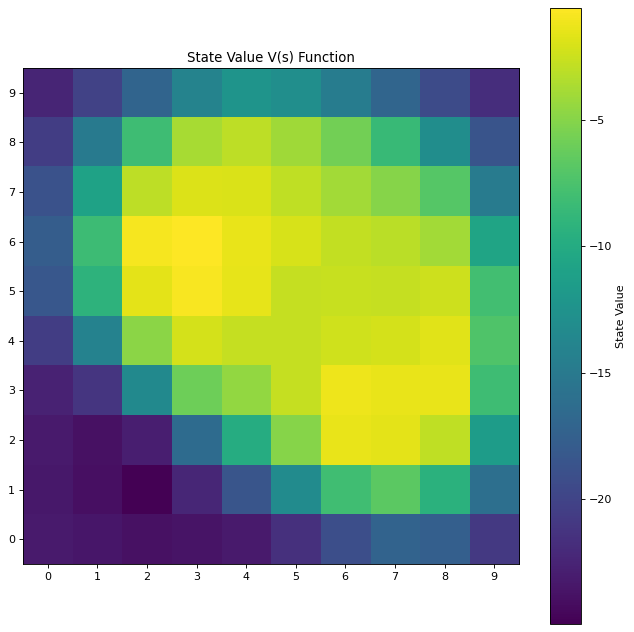

In [21]:
plt.figure()
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.swapaxes(z,0,1))
plt.colorbar(label='State Value')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, world.size[0], dtype=int))
plt.yticks(np.arange(0, world.size[1], dtype=int))
plt.title('State Value V(s) Function')
plt.show()

To show that we have trained a network that gives good state values corresponding to a functional agent, we use the following approaches:

1. **Visualize the State Value Function**:
    - The state value function \(V(s)\) is visualized by calculating the maximum Q-value for each state. 
    - In the plot, higher values near the goal and lower values near hazards (like fire) indicate that the agent correctly values states that are beneficial and avoids states that are harmful.
    - The visualization provides a clear picture of how the agent perceives the environment and the expected rewards from different states.

2. **Dynamic Play Simulation**:
    - Use a dynamic play plotting function to simulate the agent's path from the start state to the goal state using the trained policy.
    - If the agent consistently follows an optimal path, avoiding hazards and reaching the goal, this demonstrates the effectiveness of the learned policy.

By visualizing the state value function and simulating the agent's dynamic play, we can clearly demonstrate that the trained network provides good state values and that the corresponding policy results in a functional agent. The state value function plot shows how the agent values different states, while the dynamic play simulation confirms that these values lead to optimal behavior in the environment.

# Plotting : Dynamic play

To challenge the agent increase the probability of fire spread, and turn on and increase the wind.

KeyboardInterrupt: 

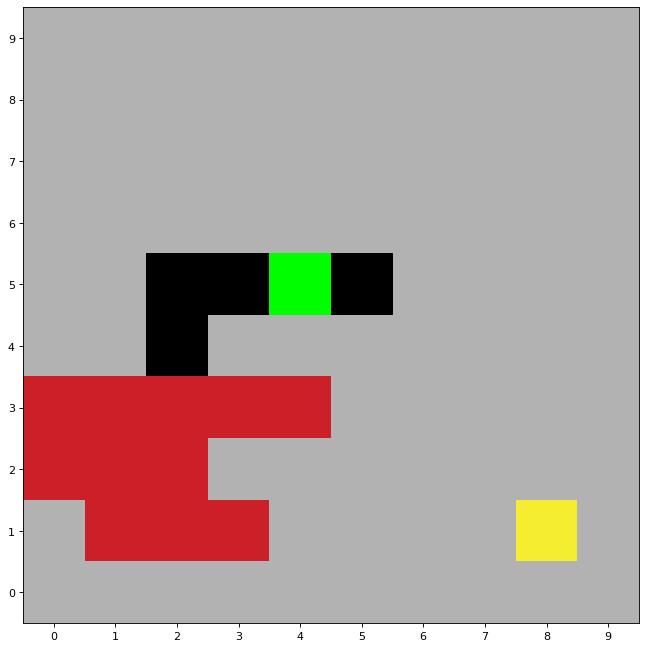

In [22]:
for a in range(100):
    # fire spreading
    world.prob_spread = 0.5
    world.wind = 0.1
    is_wind = False

    #get original state  
    state, player_coordinate = world.make_state(True)
    path=np.array([player_coordinate])
    
    # setup figure
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

    done = False
    count =0
    while (not done) and (count <20) :
        count = count + 1
        
        # plot it 
        plot_grid = world.make_RGB_grid(state,path)
        plt.imshow(np.swapaxes(np.array(plot_grid),0,1))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(0, world.size[0], dtype=int))
        plt.yticks(np.arange(0, world.size[1], dtype=int))
        # clear figure and wait
        clear_output(wait=True)
        # time.sleep(1)
        display(fig)

        # find action
        q_state = policy_model.predict(state.reshape(1,world.size[0],world.size[1],world.layers))
        # get best action, no epsilon greedy
        action = np.argmax(q_state)      
        # make the move
        next_state ,next_player_coordinate, reward , done = world.make_move(state,action,player_coordinate,is_wind)

        # update state 
        state = next_state
        player_coordinate = next_player_coordinate

        if not done :
            path=np.append(path,[player_coordinate],axis = 0)

        # let fire spread
        new_state, fire_spread = world.let_fire_spread(state)
        if fire_spread :
            print("Fire spread")
            state = new_state
    plt.close()

**Dynamic Play Simulation**:
   - In the dynamic play simulations, the agent’s path from the start to the goal should generally avoid hazardous areas and demonstrate efficient navigation towards the goal. If the agent consistently reaches the goal while minimizing contact with hazards, it indicates that the trained policy is effective.

### Dynamic Play Adjustments

To challenge the agent, we increased the difficulty by adjusting the following parameters:

1. **Increased Fire Spread Probability**: `world.prob_spread = 0.7`
   - This increases the likelihood of fire spreading, making the environment more challenging.

2. **Increased Wind Probability**: `world.wind = 0.3`
   - Turning on the wind and increasing its probability introduces more randomness into the agent's actions.

3. **Dynamic Play Execution**:
   - The dynamic play runs for 100 episodes, plotting the agent's path with the new settings.
   - The agent's performance can be observed through visualizations and its ability to reach the goal while avoiding spreading fire and dealing with wind.

These adjustments make the task harder, allowing us to observe how well the agent handles more complex and unpredictable scenarios.

KeyboardInterrupt: 

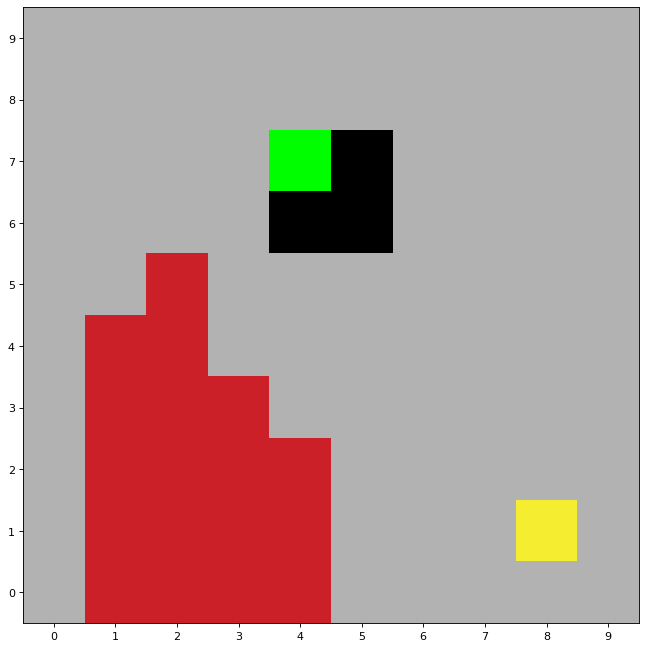

In [23]:
# Dynamic game replay

for a in range(100):
    # Increase fire spreading probability and wind effect
    world.prob_spread = 0.7  # Increased fire spread probability
    world.wind = 0.3  # Increased wind probability
    is_wind = True

    # Get original state  
    state, player_coordinate = world.make_state(True)
    path = np.array([player_coordinate])
    
    # Setup figure
    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

    done = False
    count = 0
    while (not done) and (count < 20):
        count += 1
        
        # Plot it 
        plot_grid = world.make_RGB_grid(state, path)
        plt.imshow(np.swapaxes(np.array(plot_grid), 0, 1))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(0, world.size[0], dtype=int))
        plt.yticks(np.arange(0, world.size[1], dtype=int))
        
        # Clear figure and wait
        clear_output(wait=True)
        display(fig)

        # Find action
        q_state = policy_model.predict(state.reshape(1, world.size[0], world.size[1], world.layers))
        # Get best action, no epsilon greedy
        action = np.argmax(q_state)      
        
        # Make the move
        next_state, next_player_coordinate, reward, done = world.make_move(state, action, player_coordinate, is_wind)

        # Update state 
        state = next_state
        player_coordinate = next_player_coordinate

        if not done:
            path = np.append(path, [player_coordinate], axis=0)

        # Let fire spread
        new_state, fire_spread = world.let_fire_spread(state)
        if fire_spread:
            print("Fire spread")
            state = new_state

    plt.close()

- **Convergence**: If the agent’s path to the goal becomes more consistent and direct over time, it shows that the agent has learned an effective policy.
- **Adaptability**: If the agent can still reach the goal despite increased randomness from wind and fire spread, it indicates a robust policy.
- **Exploration Decline**: The reduction in exploratory moves (as seen by fewer random deviations in later episodes) demonstrates successful epsilon decay and policy exploitation..

Our visualizations shows that the agent does not yet reach reliably- the goal, while avoiding hazards. The number of training games is still quite less (2500), it demonstrates that the agent is not yet well-trained. Observations such as the agent’s adaptability to increased randomness and the learning curve provide additional insights into the training process and agent performance.